Modified from original at: http://matgenb.materialsvirtuallab.org/

# Introduction

This notebook demonstrates how you obtain data from the Materials Project using pymatgen's interface to the Materials API. You can find more info about the Materials Project at: https://www.materialsproject.org/

## Notice: You need to get a "key" from the Materials Project website to use this notebook.

To get a key, go to: https://materialsproject.org/dashboard.  You then have to either login or give your email address and they will email you a login link.  Then use their Key Generator to get a key.  The key generator looks like this:

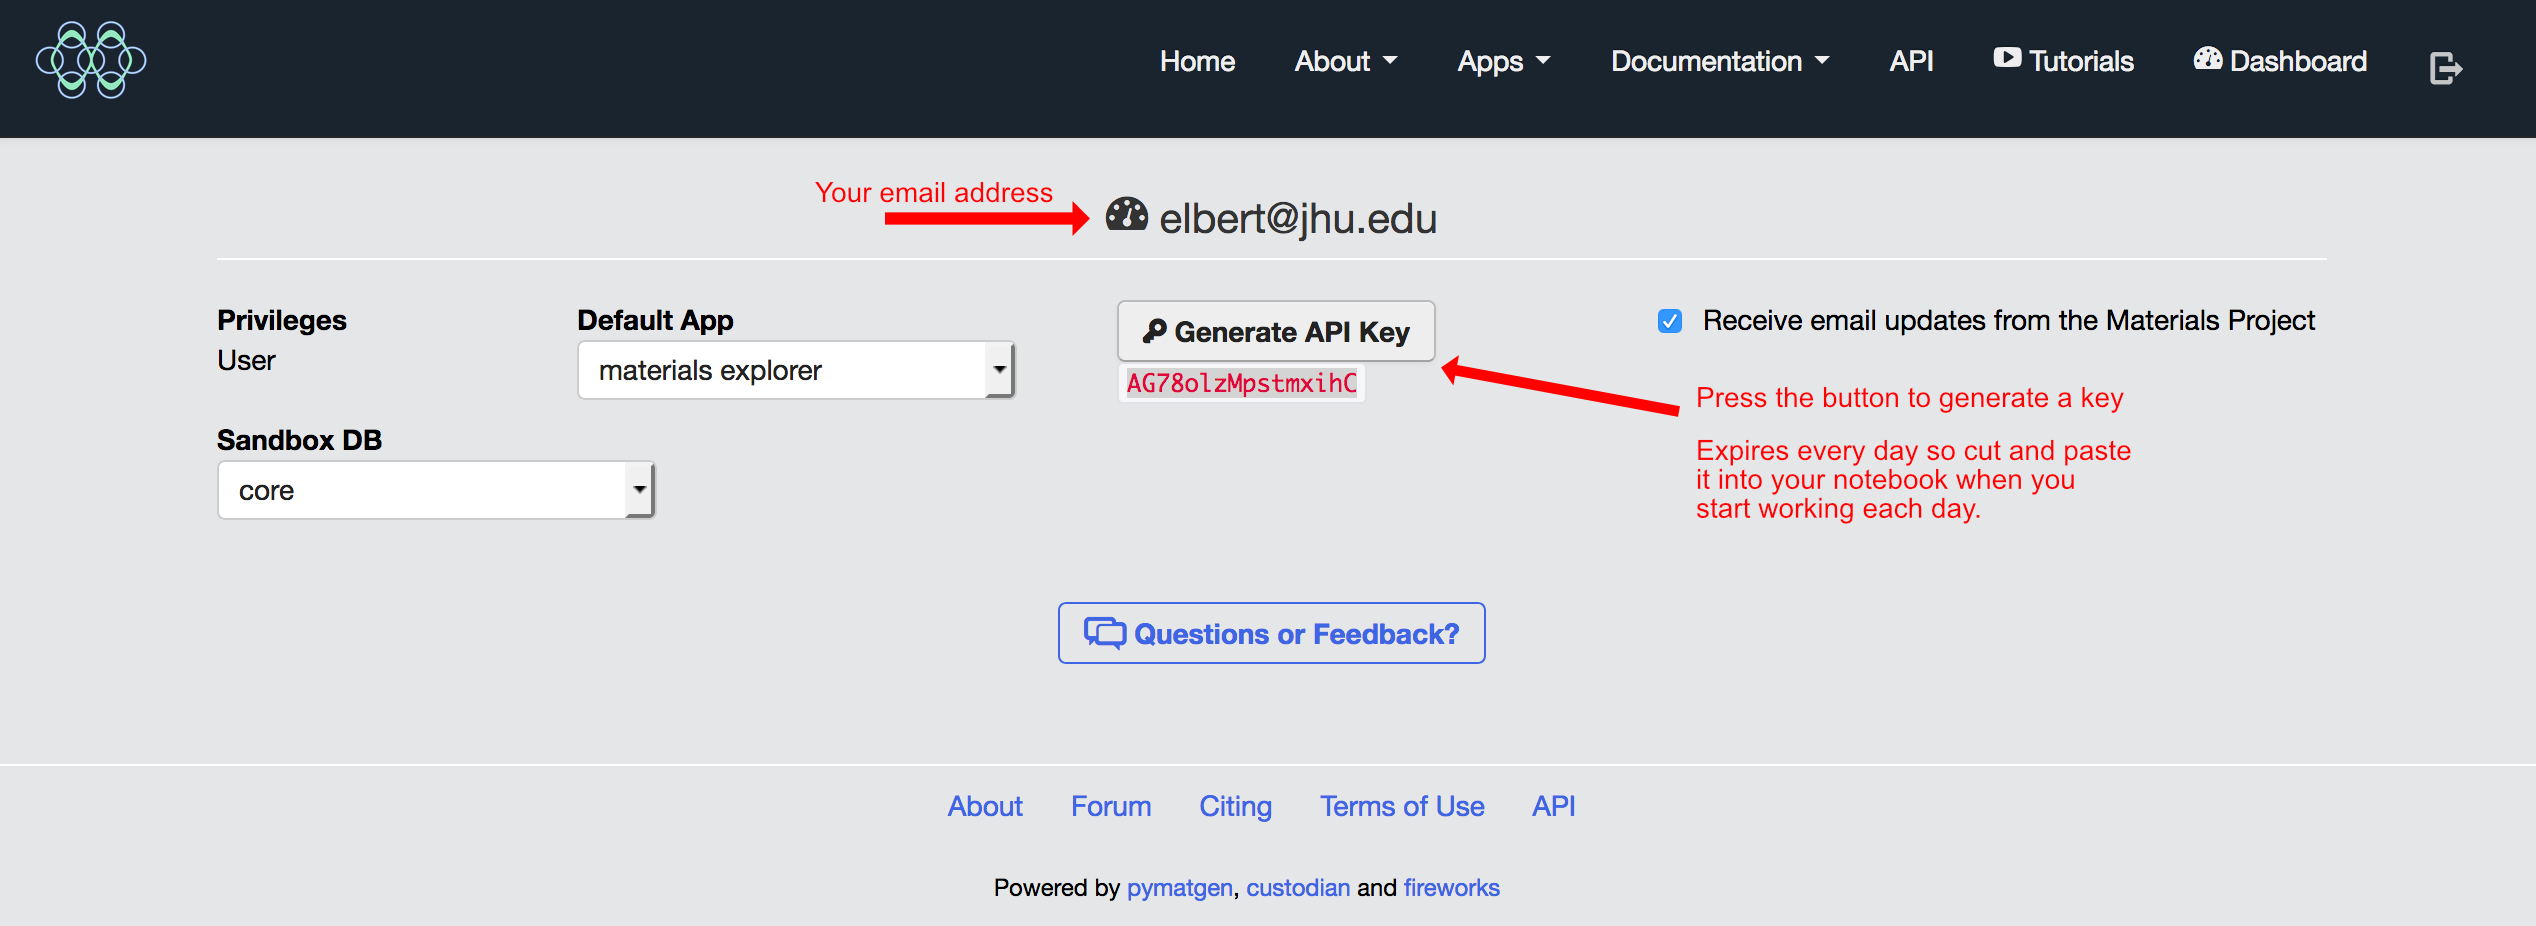

In [ ]:
from pymatgen import MPRester, Composition
import re
import pprint

# Make sure that you have a Materials API key. You get that from the Materials Project
# dashboard on their website: https://www.materialsproject.org/dashboard. 
# Once you have your key, put it into the next statement as the argument for MPRester. 
# as MPRester("MY_API_KEY").  You need to put the key in quotes within the call on the next line:

mpr = MPRester("TP8h2TsKtL5Q1Nvk")

# Getting structures with material ids

Let's say you want to find all structures with similar stoichiometry to Fe<sub>2</sub>O<sub>3</sub>. Create a query to the Materials Project:eeee

In [ ]:
comp = Composition("Fe2O3")
anon_formula = comp.anonymized_formula
# We need to convert the formula to the dict form used in the database.
anon_formula = {m.group(1): int(m.group(2)) 
                for m in re.finditer(r"([A-Z]+)(\d+)", anon_formula)}

data = mpr.query({"anonymous_formula": anon_formula}, 
                 properties=["task_id", "pretty_formula", "structure"])
print(len(data))  #Should show ~600 data.

In [ ]:
# data now contains a list of dict. This shows you what each dict has.
# Note that the mp id is named "task_id" in the database itself.
pprint.pprint(data[0])  

# Getting band structures

Band structures are fairly large objects. It is not recommended that you download large quantities of bandstructures in one shot, but rather just download the ones you need.

In [ ]:
bs = mpr.get_bandstructure_by_material_id("mp-20470")

In [ ]:
from pymatgen.electronic_structure.plotter import BSPlotter
%matplotlib inline

In [ ]:
plotter = BSPlotter(bs)
plotter.show()

# Getting elastic constants

We have 5000 elastic constants and growing. You can easily get all the elastic data with materials ids as follows.

In [ ]:
elastic_data = mpr.query({"elasticity": {"$exists": True}}, 
                         properties=["task_id", "pretty_formula", "elasticity"])

In [ ]:
print(len(elastic_data))
pprint.pprint(elastic_data[0])

# More resources

In general, almost any data can be obtained from MP using the MPRester, either via the high-level functions or the very powerful "query" method.

For more complex queries, you can refer to the documentation for the Materials API at https://github.com/materialsproject/mapidoc. 

# Fitting structures

Pymatgen has its own structure matching algorithm, which we have used to effectively reduce the 130,000 structures in ICSD to ~60,000 - 70,000 structures. It is fast and accurate. Here's an example of how it works.

In [ ]:
from pymatgen.analysis.structure_matcher import StructureMatcher

In [ ]:
m = StructureMatcher() # You can customize tolerances etc., but the defaults usually work fine.

In [ ]:
s1 = data[0]["structure"]
print(s1)
s2 = s1.copy()
s2.apply_strain(0.1)
print(s2)

In [ ]:
print(m.fit(s1, s2)) 

For something more challenging, let's see how many structures are similar to Gd2O3

In [ ]:
matches = []
for d in data:
    if m.fit_anonymous(d["structure"], s1):
        matches.append(d)

In [ ]:
# The above fitting took a few seconds. We have 32 similar structures.
print(len(matches))

In [ ]:
# Let's see a few of the matches.
pprint.pprint(matches[0])
pprint.pprint(matches[1])
pprint.pprint(matches[2])

You can see that we have successfully found iso-structural materials!